# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [2]:
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize as resz
from PIL import Image, ImageOps
from fsl.wrappers import fslsplit, fslmerge

from utils.nifti import compress_nifti
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


In [3]:
import utils.vedo
import importlib
importlib.reload(utils.vedo)
from utils.vedo import *

file_2 = '../example/GM_mask_xfigure_roi_NEW.nii.gz'
file_1 = '../example/mean_FA.nii.gz'

img_data = nib.load(file_1).get_fdata()
mask_data = nib.load(file_2).get_fdata()

In [4]:
# Load the image
img = nib.load(file_1)

# Normalize the image
img_data = img.get_fdata()
img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

# Trehshold the image background
img_data[img_data < 0] = 0

# # Increase the contrast
# img_data = img_data ** 0.9

img = nib.Nifti1Image(img_data, img.affine, img.header)

mask = nib.load(file_2)
plot_volume_cloud(img, mask, cmap='bone')


In [35]:
import plotly.graph_objects as go

def plot_3d_overlap(ground_truth, prediction, processed_image, alpha=0.2, density=300000, threshold=0.1, cmap='gray'):
    # Get the brain mask
    brain_volume = processed_image
    gt_volume = ground_truth
    prediction_volume = prediction
    
    # Get Indices
    gt_indices = np.argwhere(gt_volume > 0)
    brain_indices = np.argwhere(brain_volume > threshold)  # remove noise
    prediction_indices = np.argwhere(prediction_volume > 0)

    # Randomly sample points based on the specified density
    if len(brain_indices) > density:
        brain_indices = brain_indices[np.random.choice(len(brain_indices), density, replace=False)]

    # Get matrix values for color mapping
    brain_colors = brain_volume[brain_indices[:, 0], brain_indices[:, 1], brain_indices[:, 2]]

    # Normalize brain colors to [0, 1] and enhance contrast
    brain_colors_normalized = (brain_colors - np.min(brain_colors)) / (np.max(brain_colors) - np.min(brain_colors))
    brain_colors_enhanced = np.clip(brain_colors_normalized *2, 0, 1)

    # Map normalized brain colors to marker sizes (brighter dots larger)
    min_marker_size = 2
    max_marker_size = 3
    brain_marker_sizes = min_marker_size + brain_colors_enhanced * (max_marker_size - min_marker_size)

    # Create 3D scatter plot for the brain mask
    brain_scatter = go.Scatter3d(
        x=brain_indices[:, 0],
        y=brain_indices[:, 1],
        z=brain_indices[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            opacity=0.05,
            color=brain_colors_enhanced,
            colorscale=cmap,
            cmin=0,
            cmax=1,
        ),
        name='Brain Mask Point Cloud'
    )

    # Create 3D scatter plot for the ground truth
    gt_scatter = go.Scatter3d(
        x=gt_indices[:, 0],
        y=gt_indices[:, 1],
        z=gt_indices[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color='black',
            opacity=alpha
        ),
        name='Ground Truth'
    )

    # Custom colormap for prediction (red, green, blue, yellow, purple)
    color_scale = [[0, 'blue'], [0.25, 'green'], [0.5, 'red'], [0.75, 'yellow'], [1, 'purple']]

    # Create 3D scatter plot for the prediction with label-based coloring
    prediction_scatter = go.Scatter3d(
        x=prediction_indices[:, 0],
        y=prediction_indices[:, 1],
        z=prediction_indices[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=prediction_volume[prediction_indices[:, 0], prediction_indices[:, 1], prediction_indices[:, 2]],
            colorscale=color_scale,
            opacity=alpha,
            showscale=False
        ),
        name='Prediction'
    )

    # Create figure
    fig = go.Figure(data=[brain_scatter, gt_scatter, prediction_scatter])

    # Set layout properties
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        width=1000,
        height=700,
        title='3D Plot - Brain Mask Point Cloud',
        annotations=[
            dict(
                text='You can switch on and off the masks by clicking',
                x=1.05,
                y=1,
                align='right',
                font=dict(family='Arial', size=12, color='black'),
            ),
        ],
    )

    # Show figure
    fig.show()

 ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd']

In [38]:
_img_data = img_data

plot_3d_overlap(mask_data, mask_data, _img_data, alpha=0.2, density=280000, threshold=0.05, cmap='plasma')

In [258]:
import nibabel as nib
import numpy as np
path = 'I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1782\DTI\Isch_PAL_PPIAKO_1782_dti_orig.nii.gz'
out_path = 'I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1782\DTI\Isch_PAL_PPIAKO_1782_anat_orig.nii.gz'

def time_mean(input_path, output_path):
    # Load NIfTI image
    img = nib.load(input_path)

    # print shape
    print(img.shape) # 5 dimensions (x, y, z, 32 directions, 2 b-values)

    # Decresase the number of dimensions to 4 (32*2 = 64) by flattening the last two dimensions
    data = img.get_fdata()
    data = np.reshape(data, data.shape[:3] + (-1,))
    img = nib.Nifti1Image(data, img.affine)

    print(img.shape) # 4 dimensions (x, y, z, 64)

    # Split the image into multiple volumes
    volumes = nib.funcs.four_to_three(img)

    # Merge the first four volumes
    merged_img = nib.funcs.concat_images([volumes[0], volumes[1], volumes[2], volumes[3]])

    # Save the merged image
    nib.save(merged_img, output_path.replace('anat_orig', 'merged_orig'))

    # Take the mean of the merged image to form a single volume
    merged_img_data = merged_img.get_fdata()
    mean_img_data = np.mean(merged_img_data, axis=-1)
    mean_img = nib.Nifti1Image(mean_img_data, merged_img.affine)

    # Save the mean image
    nib.save(mean_img, output_path)

for root, dirs, files in os.walk('I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto'):
    for case in dirs:
        print(case)
        dti_path = os.path.join(root, case, 'DTI')
        for root2, dirs2, files2 in os.walk(dti_path):
            for file in files2:
                if 'dti_orig' in file:
                    input_path = os.path.join(root2, file)
                    output_path = os.path.join(root2, file.replace('dti_orig', 'anat_orig'))
                    print(input_path)
                    print(output_path)
                    time_mean(input_path, output_path)
                    print('done')
        print('done')


Isch_PAL_PPIAKO_1767
I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1767\DTI\Isch_PAL_PPIAKO_1767_dti_orig.nii.gz
I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1767\DTI\Isch_PAL_PPIAKO_1767_anat_orig.nii.gz
(120, 120, 28, 32, 2)
(120, 120, 28, 64)
done
done
Isch_PAL_PPIAKO_1777
I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1777\DTI\Isch_PAL_PPIAKO_1777_dti_orig.nii.gz
I:\DannoCerebraleAcuto_MRI\Cariplo Pasetto\Isch_PAL_PPIAKO_1777\DTI\Isch_PAL_PPIAKO_1777_anat_orig.nii.gz
(120, 120, 28, 32, 2)


KeyboardInterrupt: 

In [17]:
mapping = {
    151: 9,
    215: 9,
    103: 9,
    47: 9,
    152: 9,
    76: 9,
    2: 9,
    223: 9,
    245: 9,
    222: 9,
    230: 9,
    190: 16,
    164: 16,
    180: 16,
    14: 9,
    43: 9,
    109: 9,
    68: 12,
    18: 9,
    168: 9,
    66: 15,
    219: 9,
    125: 9,
    11: 9,
    22: 9,
    154: 14,
    144: 14,
    199: 15,
    106: 15,
    150: 9,
    213: 9,
    12: 9,
    102: 9,
    107: 9,
    77: 13,
    61: 9,
    212: 17,
    120: 9,
    153: 9,
    155: 14,
    105: 9,
    145: 9,
    116: 9,
    185: 9,
    131: 9,
    63: 15,
    205: 9,
    159: 9,
    17: 14,
    140: 9,
    214: 9,
    4: 17,
    10: 9,
    100: 9,
    118: 9,
    119: 9,
    146: 21,
    156: 9,
    157: 9,
    174: 9,
    187: 9,
    194: 9,
    51: 9,
    115: 9,
    23: 9,
    247: 9,
    52: 9,
    176: 9,
    202: 9,
    123: 9,
    45: 9,
    242: 9,
    209: 9,
    64: 6,
    130: 6,
    181: 6,
    114: 9,
    143: 9,
    9: 9,
    8: 2,
    218: 9,
    166: 9,
    16: 5,
    19: 9,
    25: 9,
    211: 9,
    122: 9,
    54: 4,
    44: 4,
    99: 5,
    6: 5,
    250: 9,
    113: 9,
    112: 9,
    101: 9,
    207: 9,
    57: 3,
    161: 9,
    210: 7,
    20: 9,
    53: 9,
    55: 4,
    5: 9,
    95: 9,
    216: 9,
    85: 9,
    133: 9,
    13: 5,
    225: 9,
    59: 9,
    7: 4,
    240: 9,
    124: 9,
    204: 7
}

# # FLipped
# mapping = {
#     151: 9,
#     215: 9,
#     103: 9,
#     47: 9,
#     152: 9,
#     76: 9,
#     2: 9,
#     223: 9,
#     245: 9,
#     222: 9,
#     230: 9,
#     190: 6,
#     164: 6,
#     180: 6,
#     14: 9,
#     43: 9,
#     109: 9,
#     68: 2,
#     18: 9,
#     168: 9,
#     66: 5,
#     219: 9,
#     125: 9,
#     11: 9,
#     22: 9,
#     154: 4,
#     144: 4,
#     199: 5,
#     106: 5,
#     150: 9,
#     213: 9,
#     12: 9,
#     102: 9,
#     107: 9,
#     77: 3,
#     61: 9,
#     212: 7,
#     120: 9,
#     153: 9,
#     155: 4,
#     105: 9,
#     145: 9,
#     116: 9,
#     185: 9,
#     131: 9,
#     63: 5,
#     205: 9,
#     159: 9,
#     17: 4,
#     140: 9,
#     214: 9,
#     4: 7,
#     10: 9,
#     100: 9,
#     118: 9,
#     119: 9,
#     146: 21,
#     156: 9,
#     157: 9,
#     174: 9,
#     187: 9,
#     194: 9,
#     51: 9,
#     115: 9,
#     23: 9,
#     247: 9,
#     52: 9,
#     176: 9,
#     202: 9,
#     123: 9,
#     45: 9,
#     242: 9,
#     209: 9,
#     64: 16,
#     130: 16,
#     181: 16,
#     114: 9,
#     143: 9,
#     9: 9,
#     8: 12,
#     218: 9,
#     166: 9,
#     16: 15,
#     19: 9,
#     25: 9,
#     211: 9,
#     122: 9,
#     54: 14,
#     44: 14,
#     99: 15,
#     6: 15,
#     250: 9,
#     113: 9,
#     112: 9,
#     101: 9,
#     207: 9,
#     57: 13,
#     161: 9,
#     210: 17,
#     20: 9,
#     53: 9,
#     55: 14,
#     5: 9,
#     95: 9,
#     216: 9,
#     85: 9,
#     133: 9,
#     13: 15,
#     225: 9,
#     59: 9,
#     7: 14,
#     240: 9,
#     124: 9,
#     204: 17
# }
# mapping = {
#     0:0,
#     1:1,
#     2:12,
#     3:13,
#     4:14,
#     5:15,
#     6:16,
#     7:17,
#     9:9,
#     12:2,
#     13:3,
#     14:4,
#     15:5,
#     16:6,
#     17:7,
#     21:21,
# }


# mapping ={
#     1:1,
#     2:6,
#     3:16,
#     10:2,
#     11:12,
#     15:2,
#     16:12,
#     12:3,
#     13:13,
#     14:21,
#     4:5,
#     5:15,
#     8:7,
#     9:17,
#     6:4,
#     7:14,


# }


CASE:  CONC_fm_17_C_18
Processed:  CONC_fm_17_C_18_roi_Labels.nii.gz
Processed voxel size:  (1.0000092, 1.0000001, 1.0000094)
Saving...


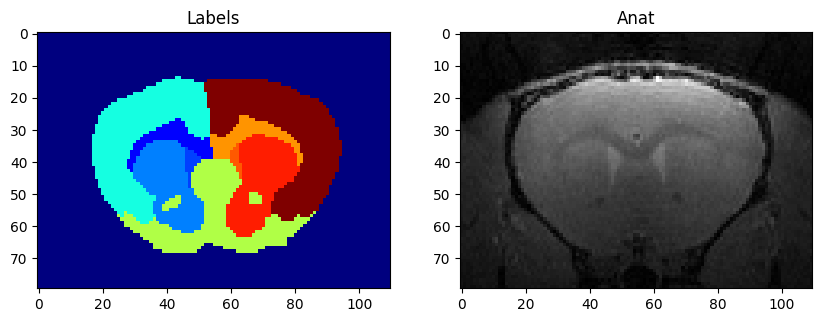

Unique values:  [ 0.  2.  3.  4.  5.  6.  7.  9. 12. 13. 14. 15. 16. 17. 21.]
------------------


In [18]:
path='..\data_fix'
path = os.path.join(path, 'flip')

import preprocessing.preprocessor
import importlib
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, CorrectX10
from scipy.ndimage import zoom


preprocessor = Preprocessor( steps=[CorrectX10()]) 
# preprocessor = MRIProcessor(img_size=(256, 256, 256), correct_x10=True, verbose=True)
# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        id = name
        print('CASE: ', id)
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    
                    # if file_name.endswith("brain_mask.nii.gz") and not file_name.startswith("."):
                    #     # load 
                    #     print('Original: ', file_name)
                    #     orig = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     # cast to binary
                    #     orig_data = orig.get_fdata()
                    #     orig_data[orig_data > 0.5] = 1
                    #     orig_data[orig_data <= 0.5] = 0
                    #     orig = nib.Nifti1Image(orig_data, orig.affine, orig.header)
                    #     print('Saving...')
                    #     new_name = file_name.replace('brain_mask', 'brain_mask')
                    #     nib.save(orig, os.path.join(path, name, sub_name, new_name))
                        
                    # if file_name.endswith("Labels.nii.gz") and not file_name.startswith(".") and not file_name.endswith("roi_Labels.nii.gz"):
                    #     print('Original: ', file_name)
                    #     orig = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     print('Original voxel size: ', orig.header.get_zooms())
                    #     corrected = preprocessor.preprocess(orig)
                    #     print('Corrected voxel size: ', corrected.header.get_zooms())
                    #     print('Saving...')
                    #     new_name = file_name.replace('brain_mask', 'brain_mask')
                    #     nib.save(corrected, os.path.join(path, name, sub_name, new_name))


                    # if file_name.endswith("mask_X10.nii.gz") and not file_name.startswith("."):
                    #     print('Processed: ', file_name)
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     size = proc.header.get_zooms()
                    #     print('Processed voxel size: ', size)
                    #     if size[0] > 0.5:
                    #         print('Dividing by 10')
                    #         resized, _ = preprocessor.preprocess(proc)
                    #         print('Processed voxel size: ', resized.header.get_zooms())
                    #         print('Saving...')
                    #         new_name = file_name.replace('mask_X10', 'brain_mask')
                    #         nib.save(resized, os.path.join(path, name, sub_name, new_name))

                    # if file_name.endswith("anat_orig.nii.gz") and not file_name.startswith("."):
                    #     print('Processed: ', file_name)
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     size = proc.header.get_zooms()
                    #     print('Processed voxel size: ', size)
                    #     if size[0] > 0.5:
                    #         print('Dividing by 10')
                    #         resized, _ = preprocessor.res_nifti(proc)
                    #         print('Processed voxel size: ', resized.header.get_zooms())
                    #         print('Saving...')
                    #         #new_name = file_name.replace('mask_X10', 'brain_mask')
                    #         nib.save(resized, os.path.join(path, name, sub_name, file_name))

                    if file_name.endswith("roi_Labels.nii.gz") and not file_name.startswith("."):
                        print('Processed: ', file_name)
                        proc = nib.load(os.path.join(path, name, sub_name, file_name))
                        brain_mask = nib.load(os.path.join(path, name, sub_name, file_name.replace('roi_Labels', 'brain_mask')))
                        size = proc.header.get_zooms()
                        proc = preprocessor.preprocess(proc)
                        print('Processed voxel size: ', size)

                        # apply the mapping to labels in proc 
                        data = proc.get_fdata()
                        empty = np.zeros_like(data)
                        # load the brain mask as value 9
                        empty[brain_mask.get_fdata() > 0] = 9
                        for k, v in mapping.items():
                            empty[data == k] = v
                        data = empty
                        proc = nib.Nifti1Image(data, proc.affine, proc.header)
                        #if size[0] > 0.5:
                        # print('Dividing by 10')
                        # resized, _ = preprocessor.res_nifti(proc)
                        # print('Processed voxel size: ', resized.header.get_zooms())
                        print('Saving...')
                        new_name = file_name.replace('roi_Labels', 'Labels')

                        # plot anat orig and new labels
                        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                        ax[0].imshow(proc.get_fdata()[:, 100, :], cmap='jet')
                        ax[0].set_title('Labels')

                        anat = nib.load(os.path.join(path, name, sub_name, file_name.replace('roi_Labels', 'anat_orig'))
                        )
                        ax[1].imshow(anat.get_fdata()[:, 100, :], cmap='gray')
                        ax[1].set_title('Anat')
                        plt.show()

                        print('Unique values: ', np.unique(data))
                        nib.save(proc, os.path.join(path, name, sub_name, new_name))

                    # if file_name.endswith("Labels.nii.gz") and not file_name.startswith(".") and not file_name.endswith("roi_Labels.nii.gz"):
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     # apply the mapping to labels in proc 
                    #     data = proc.get_fdata()
                    #     empty = np.zeros_like(data)

                    #     # Apply identity mapping
                    #     for k, v in mapping.items():
                    #         empty[data == k] = v
                    #     data = empty

                    #     proc = nib.Nifti1Image(data, proc.affine, proc.header)
                    #     print('Saving...')
                    #     new_name = file_name.replace('Labels', 'Labels')
                    #     nib.save(proc, os.path.join(path, name, sub_name, new_name))
                        
                    # if file_name.endswith("Labels.nii.gz") and not file_name.startswith(".") and not file_name.endswith("roi_Labels.nii.gz"):
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     # apply the mapping to labels in proc 
                    #     data = proc.get_fdata()
                    #     empty = np.zeros_like(data)

                    #     print('Unique values: ', np.unique(data))

                    #     # crete brain mask with value 1 where there is brain
                    #     brain_mask = np.zeros_like(data)
                    #     brain_mask[data > 0] = 1
                    #     brain_mask = nib.Nifti1Image(brain_mask, proc.affine, proc.header, dtype=np.float64)
                    #     print('Saving brain mask...')
                    #     new_name = file_name.replace('Labels', 'brain_mask')
                    #     nib.save(brain_mask, os.path.join(path, name, sub_name, new_name))

                    # if file_name.endswith("_Labels.nii.gz") and not file_name.startswith(".") and not file_name.endswith("roi_Labels.nii.gz"):
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     # apply the mapping to labels in proc 
                    #     data = proc.get_fdata()
                    #     # # convert to int64
                    #     print('Unique values: ', np.unique(data))
                        
                    #     # for each unique value in data, convert it to float64
                    #     for i, v in enumerate(np.unique(data)):
                    #         print(v)
                    #         # round v to closest integer
                    #         data[np.isclose(data, v, rtol=1e-5, atol=1e-8)] = np.int64(np.round(v))
                        

                    #     # print('Unique values: ', np.unique(data))
                    #     # empty = np.zeros_like(data)
                    #     # for k, v in mapping.items():
                    #     #     # where data is equal to k, set it to v
                    #     #     print('Mapping: ', np.float64(k), ' to ', v)
                    #     #     mask = np.isclose(data, np.float64(k), rtol=1e-5, atol=1e-8)
                    #     #     empty[mask] = v

                    #     # data = empty
                    #     proc = nib.Nifti1Image(data, proc.affine, proc.header)
                    #     print('Saving...')
                    #     new_name = file_name.replace('_Labels', '_Labels')
                    #     nib.save(proc, os.path.join(path, name, sub_name, new_name))


                    # if file_name.endswith("X10_N4.nii.gz") and not file_name.startswith("."):
                    #     print('Processed: ', file_name)
                    #     proc = nib.load(os.path.join(path, name, sub_name, file_name))
                    #     size = proc.header.get_zooms()
                    #     print('Processed voxel size: ', size)
                    #     if size[0] > 0.5:
                    #         print('Dividing by 10')
                    #         resized, _ = preprocessor.res_nifti(proc)
                    #         print('Processed voxel size: ', resized.header.get_zooms())
                    #         print('Saving...')
                    #         new_name = file_name.replace('X10_N4', 'N4')
                    #         nib.save(resized, os.path.join(path, name, sub_name, new_name))
                        


        print("------------------")

In [19]:
path='..\data_fix'
path = os.path.join(path, 'rare')

# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        id = name
        print('CASE: ', id)
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    
                    # If file_name contains 'nodif' substring, replace it with ID
                    if file_name.endswith('brain_mask.nii'):
                        #new_file_name = file_name.replace('brain_mask_24', 'brain_mask')
                        # print dir
                        #print("------------------")
                        #print(id)
                        print(file_name)
                        # compress nii file into nii.gz
                        compress_nifti(os.path.join(path, name, sub_name, file_name))
                        #print(new_file_name)
                        # rename or overwrite the file with the new name if already exists

                        # Rename the file
                        #os.rename(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, new_file_name))
        print("------------------")

CASE:  TBI_fm_19_49
------------------
CASE:  TBI_fm_19_50
------------------
CASE:  TBI_fm_19_51
------------------
CASE:  TBI_fm_19_53
------------------
CASE:  TBI_fm_19_54
------------------
CASE:  TBI_fm_19_55
------------------
CASE:  TBI_fm_19_56
------------------
CASE:  TBI_fm_19_58
------------------
CASE:  TBI_fm_19_59
------------------
CASE:  TBI_fm_19_60
------------------
CASE:  TBI_fm_19_61
------------------
CASE:  TBI_fm_19_62
------------------
CASE:  TBI_fm_19_64
------------------
CASE:  TBI_fm_19_65
------------------
CASE:  TBI_fm_19_67
------------------
CASE:  TBI_fm_19_68
------------------
CASE:  TBI_gv_17_48
------------------
CASE:  TBI_gv_17_49
------------------
CASE:  TBI_gv_17_50
------------------
CASE:  TBI_gv_17_51
------------------
CASE:  TBI_gv_17_52
------------------
CASE:  TBI_gv_17_53
------------------
CASE:  TBI_gv_17_57
------------------
CASE:  TBI_gv_17_58
------------------
CASE:  TBI_gv_18_174
------------------
CASE:  TBI_gv_18_175
---

In [20]:
path='..\data_fix'
path = os.path.join(path, 'DTI_luke')

# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        id = name
        print(id)
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'DTI':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    
                    # If file_name contains 'nodif' substring, replace it with ID
                    if file_name.endswith('brain_mask.nii'):
                        #new_file_name = file_name.replace('brain_mask_24', 'brain_mask')
                        # print dir
                        #print("------------------")
                        #print(id)
                        print(file_name)
                        #print(new_file_name)
                        # compress nii file into nii.gz
                        compress_nifti(os.path.join(path, name, sub_name, file_name))
                        
                        # Rename the file
                        #os.rename(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, new_file_name))
            print("------------------")

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: '..\\data_fix\\DTI_luke'

In [ ]:
path='..\dataset_skullstripping'
path = os.path.join(path, 'DTI')

# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        id = name
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'DTI':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    # If file_name contains 'nodif' substring, replace it with ID
                    if 'mask_dti' in file_name:
                        new_file_name = file_name.replace('mask_dti', id + '_brain_mask')
                        print(new_file_name)
                        # Rename the file
                        os.rename(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, new_file_name))


TBI_MC_fp_22_146_5M_brain_mask.nii.gz


FileExistsError: [WinError 183] Impossibile creare un file, se il file esiste già: '..\\dataset_skullstripping\\DTI\\TBI_MC_fp_22_146_5M\\DTI\\mask_dti.nii.gz' -> '..\\dataset_skullstripping\\DTI\\TBI_MC_fp_22_146_5M\\DTI\\TBI_MC_fp_22_146_5M_brain_mask.nii.gz'

In [ ]:
path='..\data_fix'
path = os.path.join(path, 'highres')
name_list = []

# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        print(name)
        prefix = name
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    # check if 'Labels_with_lesion' is in the file name ignoring case
                    pos = file_name.lower().find('labels_with_lesion')
                    # if 'Labels_with_lesion' is in the file name, print the file name
                    if pos != -1:
                        print(file_name)
                        name_list.append(file_name)

                        # open nib file
                        img = nib.load(os.path.join(path, name, sub_name, file_name))
                        # get data from nib file
                        data = img.get_fdata()

                        # extract into a new nib just label equal to 1, 180, 181
                        data_new = np.zeros(data.shape)
                        data_new[data == 1] = 1
                        data_new[data == 57] = 2
                        data_new[data == 77] = 3
                        # save new nib file
                        img_new = nib.Nifti1Image(data_new, img.affine, img.header, dtype=np.float64)
                        #nib.save(img_new, os.path.join(path, name, sub_name, prefix + '_lesion_mask.nii.gz'))

                        # load nib file
                        img = nib.load(os.path.join(path, name, sub_name, prefix + '_lesion_mask.nii.gz'))
                        # check max value
                        print(np.max(img.get_fdata()))


                       
# save name_list to a txt file into path
with open(os.path.join(path, 'name_list.txt'), 'w') as f:
    for name in name_list:
        f.write("%s\n" % name)

TBI_PTE_fm_20_170
TBI_PTE_fm_20_170_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_171
TBI_PTE_fm_20_171_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_172
TBI_PTE_fm_20_172_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_173
TBI_PTE_fm_20_174
TBI_PTE_fm_20_175
TBI_PTE_fm_20_175_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_177
TBI_PTE_fm_20_177_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_178
TBI_PTE_fm_20_178_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_179
TBI_PTE_fm_20_179_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_180
TBI_PTE_fm_20_182
TBI_PTE_fm_20_182_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_183
TBI_PTE_fm_20_183_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_184
TBI_PTE_fm_20_184_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_185
TBI_PTE_fm_20_186
TBI_PTE_fm_20_187
TBI_PTE_fm_20_188
TBI_PTE_fm_20_189
TBI_PTE_fm_20_190
TBI_PTE_fm_20_191
TBI_PTE_fm_20_192
TBI_PTE_fm_20_192_roi_Labels_with_lesion.nii.gz
3.0
TBI_PTE_fm_20_193
TBI_PTE_fm_20_193_roi_Labels_wit

In [ ]:
path='..\dataset'
path = os.path.join(path, 'fix', 'PTE_MRI_giugno_2020_5m')
# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    # Find the position of the char 'C' and remove it
                    # Exlude DS_Store
                    if 'DS_Store' in file_name:
                        continue
                    
                    # Remove Anat from the name
                    new_file_name = file_name.replace('Anat_', '')
                    print(new_file_name)
                    # Rename the file
                    os.rename(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, new_file_name))




TBI_PTE_fm_20_01_5m_brain.nii.gz
TBI_PTE_fm_20_01_5m_N4.nii.gz
TBI_PTE_fm_20_01_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_01_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_02_5m_N4.nii.gz
TBI_PTE_fm_20_02_5m_anat_orig.nii.gz
TBI_PTE_fm_20_02_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_02_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_03_5m_N4.nii.gz
TBI_PTE_fm_20_03_5m_anat_orig.nii.gz
TBI_PTE_fm_20_03_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_03_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_05_5m_N4.nii.gz
TBI_PTE_fm_20_05_5m_anat_orig.nii.gz
TBI_PTE_fm_20_05_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_05_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_06_5m_N4.nii.gz
TBI_PTE_fm_20_06_5m_anat_orig.nii.gz
TBI_PTE_fm_20_06_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_06_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_08_5m_N4.nii.gz
TBI_PTE_fm_20_08_5m_anat_orig.nii.gz
TBI_PTE_fm_20_08_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_08_5m_lesion_mask.nii.gz
TBI_PTE_fm_20_09_5m_N4.nii.gz
TBI_PTE_fm_20_09_5m_anat_orig.nii.gz
TBI_PTE_fm_20_09_5m_anat_orig_x10.nii.gz
TBI_PTE_fm_20_

In [ ]:
import gzip
import shutil
path='..\dataset'
path = os.path.join(path, 'fix', 'PTE_feb_2020_3w')

def compress_nifti(input_nii_path, output_gz_path):
    # Load the NIfTI file
    nii_img = nib.load(input_nii_path)
    
    # Save the NIfTI data to a temporary file
    temp_nii_path = "temp.nii"
    nib.save(nii_img, temp_nii_path)
    
    # Compress the temporary NIfTI file into a gzip file
    with open(temp_nii_path, 'rb') as f_in:
        with gzip.open(output_gz_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # Clean up the temporary NIfTI file
    os.remove(temp_nii_path)

for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    # Compress the file with 'lesion_mask' in the name
                    if 'lesion_mask' in file_name:
                        print(file_name)
                        compress_nifti(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, file_name + '.gz'))

TBI_PTE_fm_20_01_3w_lesion_mask.nii
TBI_PTE_fm_20_02_3w_lesion_mask.nii
TBI_PTE_fm_20_03_3w_lesion_mask.nii
TBI_PTE_fm_20_05_3w_lesion_mask.nii
TBI_PTE_fm_20_06_3w_lesion_mask.nii
TBI_PTE_fm_20_08_3w_lesion_mask.nii
TBI_PTE_fm_20_09_3w_lesion_mask.nii
TBI_PTE_fm_20_12_3w_lesion_mask.nii
TBI_PTE_fm_20_13_3w_lesion_mask.nii
TBI_PTE_fm_20_15_3w_lesion_mask.nii
TBI_PTE_fm_20_16_3w_lesion_mask.nii
TBI_PTE_fm_20_17_3w_lesion_mask.nii
TBI_PTE_fm_20_18_3w_lesion_mask.nii
TBI_PTE_fm_20_20_3w_lesion_mask.nii
TBI_PTE_fm_20_21_3w_lesion_mask.nii


In [ ]:
path='..\dataset'
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        # remove 'TauKO' from the name of each dir
        new_name = name[:4] + name[10:]
        # Rename the dir
        print(new_name)
        os.rename(os.path.join(path, name), os.path.join(path, new_name))

TBI_gv_18_174
TBI_gv_18_175
TBI_gv_18_176
TBI_gv_18_177
TBI_gv_18_178
TBI_gv_18_179
TBI_gv_18_180
TBI_gv_18_181
TBI_gv_18_182
TBI_gv_18_183
TBI_gv_18_184
TBI_gv_18_185
TBI_gv_18_186
TBI_gv_18_187
TBI_gv_18_188
TBI_gv_20_101
TBI_gv_20_102
TBI_gv_20_19
TBI_gv_20_21
TBI_gv_20_22
TBI_gv_20_26
TBI_gv_20_29
TBI_gv_20_30
TBI_gv_20_31
TBI_gv_20_34
TBI_gv_20_35
TBI_gv_20_36
TBI_gv_20_39
TBI_gv_20_40
TBI_gv_20_42
TBI_gv_20_44
TBI_gv_20_45
TBI_gv_20_48
TBI_gv_20_50
TBI_gv_20_51
TBI_gv_20_53
TBI_gv_20_55
TBI_gv_20_59
TBI_gv_20_60
TBI_gv_20_61
TBI_gv_20_62
TBI_gv_20_68
TBI_gv_20_69
TBI_gv_20_70
TBI_gv_20_73
TBI_gv_20_74
TBI_gv_20_77
TBI_gv_20_80
TBI_gv_20_81
TBI_gv_20_83
TBI_gv_20_85
TBI_gv_20_86
TBI_gv_20_91
TBI_gv_20_92
TBI_gv_20_93
TBI_gv_20_97
TBI_gv_20_99
TBI_gv_20_99M


In [ ]:
import time
path='..\dataset'
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        # Print the name of each subdirectory in path
        for file_name in os.listdir(os.path.join(path, name)):
            # Move each file to Anat subdirectory and wait for the process to finish
            if file_name.endswith('.nii.gz'):
                os.rename(os.path.join(path, name, file_name), os.path.join(path, name, 'Anat', file_name))
                # Wait 1ms for the process to finish
                time.sleep(0.01)


            '''
            pos = file_name.find('TauKO_')
            if pos != -1:
                # Remove 'TauKO_' from the name of each file
                new_file_name = file_name[:pos] + file_name[pos+6:]
                # Rename the file
                print (new_file_name) 
                os.rename(os.path.join(path, name, file_name), os.path.join(path, name, new_file_name))  
            
            '''
 

In [ ]:
path='..\dataset'
# Print the name of each dir in the first layer of path
for name in os.listdir(path):
    if os.path.isdir(os.path.join(path, name)):
        #print(name)
        # Print the name of each subdirectory in path
        for sub_name in os.listdir(os.path.join(path, name)):
            # If sub_name is named Anatomy, print the name of each file in sub_name
            if sub_name == 'Anat':
                for file_name in os.listdir(os.path.join(path, name, sub_name)):
                    # Find the position of the char 'C' and remove it
                    pos = file_name.find('Ar')
                    new_file_name = file_name[:pos] + file_name[pos+3:]
                    print(new_file_name)
                    os.rename(os.path.join(path, name, sub_name, file_name), os.path.join(path, name, sub_name, new_file_name))
                    

TBI_fm_19_100_anat_orig.nii.gz
TBI_fm_19_100_anat_orig_x10.nii.gz
TBI_fm_19_100_lesion_mask.nii.gz
TBI_fm_19_100_N4.nii.gz
TBI_fm_19_101_anat_orig.nii.gz
TBI_fm_19_101_anat_orig_x10.nii.gz
TBI_fm_19_101_lesion_mask.nii.gz
TBI_fm_19_101_N4.nii.gz
TBI_fm_19_102_anat_orig.nii.gz
TBI_fm_19_102_anat_orig_x10.nii.gz
TBI_fm_19_102_lesion_mask.nii.gz
TBI_fm_19_102_N4.nii.gz
TBI_fm_19_103_anat_orig.nii.gz
TBI_fm_19_103_anat_orig_x10.nii.gz
TBI_fm_19_103_lesion_mask.nii.gz
TBI_fm_19_103_N4.nii.gz
TBI_fm_19_104_anat_mask_fb.nii
TBI_fm_19_104_anat_orig.nii.gz
TBI_fm_19_104_anat_orig_x10.nii.gz
TBI_fm_19_104_N4.nii.gz
TBI_fm_19_105_anat_mask_fb.nii
TBI_fm_19_105_anat_orig.nii.gz
TBI_fm_19_105_anat_orig_x10.nii.gz
TBI_fm_19_105_N4.nii.gz
TBI_fm_19_106_anat_mask_fb.nii
TBI_fm_19_106_anat_orig.nii.gz
TBI_fm_19_106_anat_orig_x10.nii.gz
TBI_fm_19_106_N4.nii.gz
TBI_fm_19_107_anat_mask_fb.nii
TBI_fm_19_107_anat_orig.nii.gz
TBI_fm_19_107_anat_orig_x10.nii.gz
TBI_fm_19_107_N4.nii.gz
TBI_fm_19_108_anat_orig.